# Invitae - Cohort Analysis
### Applicant - Samantha Buck
------------
### Objective
**Goal**   
We would like to perform a cohort analysis on our customers to help identify changes in ordering behavior based on their signup date.  
>  Using the two CSV files: customers.csv and orders.csv

For this exercise group the customers into week long (7 days) cohorts and then calculate how many distinct customers ordered within X days from their signup date, where X is a multiple of 7. Older cohorts will have more buckets: 0-6 days, 7-13 days, 14-20 days, etc.

--------------------

**Imports**

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

**Initial Data Import, Cleaning, Understanding Columns**

In [2]:
def import_csv(filepath):
    df = pd.read_csv(filepath)
    return df

In [3]:
customers = import_csv('customers.csv')
orders = import_csv('orders.csv')

In [4]:
def col_to_datetime(df, col):
    df[col] = pd.to_datetime(df[col])
    return df

In [5]:
customers = col_to_datetime(customers, 'created')
orders = col_to_datetime(orders, 'created')

In [6]:
customers.head()

,id,created
0,35410,2015-07-03 22:01:11
1,35417,2015-07-03 22:11:23
2,35412,2015-07-03 22:02:52
3,35413,2015-07-03 22:05:02
4,35424,2015-07-03 22:21:55


In [7]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25716 entries, 0 to 25715
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   id       25716 non-null  int64         
 1   created  25716 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1)
memory usage: 401.9 KB


In [8]:
orders.head()

,id,order_number,user_id,created
0,1709,36,344,2014-10-28 00:20:01
1,1406,7,608,2014-10-14 23:44:53
2,1716,6,2296,2014-10-28 17:47:07
3,1426,2,1225,2014-10-15 18:33:38
4,1415,6,797,2014-10-15 02:07:16


In [9]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27575 entries, 0 to 27574
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   id            27575 non-null  int64         
 1   order_number  27575 non-null  int64         
 2   user_id       27575 non-null  int64         
 3   created       27575 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 861.8 KB


*Customers*
> ```id``` matches ```user_id``` in ```Orders```
> ```created``` is the date + time the customer was created in the system

*Orders*
> ```id``` is the specific id for that order in the overall system
> ```order_number``` relates to the specific customer stating the order number for their account only
> ```created``` is the date + time the order was created in the system

**Merge Data + Create Cohorts**

In [10]:
def merged_dataframe(df1, df2, join, left_col, right_col, col_name_dict, col_to_drop):
    new_df = df1.merge(df2, how=join, left_on=left_col, right_on=right_col)
    new_df.rename(columns=col_name_dict, inplace=True)
    new_df.drop(columns=col_to_drop, inplace=True)
    return new_df

In [11]:
merged_df = merged_dataframe(customers, 
                             orders, 
                             'outer', 
                             'id', 
                             'user_id', 
                            {'id_x': 'customer_id', 'created_x': 'customer_created', 'id_y':'order_id', 
                             'created_y':'order_created'}, 
                            'user_id')

*Re-index data with a datetime index to help pull out cohorts*

In [12]:
def df_new_col_date_grouping(df, date_idx_col, date_col, timezone, time_period):
    df[date_idx_col] = df[date_col]
    df.set_index(date_idx_col, inplace=True)
    df.index.tz_localize('UTC').tz_convert(timezone)
    df.index = df.index.to_period(time_period)
    return df

In [13]:
new_merged_df = df_new_col_date_grouping(merged_df,
                                        'date_index',
                                        'customer_created',
                                        'us/pacific',
                                        'W-WED')

In [14]:
new_merged_df.head()

,customer_id,customer_created,order_id,order_number,order_created
date_index,,,,,
2015-07-02/2015-07-08,35410.0,2015-07-03 22:01:11,NaN,NaN,NaT
2015-07-02/2015-07-08,35417.0,2015-07-03 22:11:23,NaN,NaN,NaT
2015-07-02/2015-07-08,35412.0,2015-07-03 22:02:52,NaN,NaN,NaT
2015-07-02/2015-07-08,35413.0,2015-07-03 22:05:02,NaN,NaN,NaT
2015-07-02/2015-07-08,35424.0,2015-07-03 22:21:55,27970.0,1.0,2015-07-03 23:37:49


*Calculate and add a column showing how long it took between a customer signing up and placing an order*

In [15]:
def add_order_days(df, order_time_col, order_date_col, new_col, date_col):
    df[order_time_col] = df[order_date_col].sub(df[date_col])
    df[new_col] = df[order_time_col].apply(lambda x: x.days)
    return df

In [16]:
new_merged_df_2 = add_order_days(new_merged_df,'time_to_order','order_created',
                                 'Order_Group_days','customer_created')
new_merged_df_2

,customer_id,customer_created,order_id,order_number,order_created,time_to_order,Order_Group_days
date_index,,,,,,,
2015-07-02/2015-07-08,35410.0,2015-07-03 22:01:11,NaN,NaN,NaT,NaT,NaN
2015-07-02/2015-07-08,35417.0,2015-07-03 22:11:23,NaN,NaN,NaT,NaT,NaN
2015-07-02/2015-07-08,35412.0,2015-07-03 22:02:52,NaN,NaN,NaT,NaT,NaN
2015-07-02/2015-07-08,35413.0,2015-07-03 22:05:02,NaN,NaN,NaT,NaT,NaN
2015-07-02/2015-07-08,35424.0,2015-07-03 22:21:55,27970.0,1.0,2015-07-03 23:37:49,0 days 01:15:54,0.0
...,...,...,...,...,...,...,...
NaT,NaN,NaT,1504.0,1.0,2014-10-20 18:41:01,NaT,NaN
NaT,NaN,NaT,1570.0,2.0,2014-10-22 02:50:21,NaT,NaN
NaT,NaN,NaT,1387.0,1.0,2014-10-14 19:40:57,NaT,NaN


In [17]:
new_merged_df_2.describe() #7 day intervals 0-189

,customer_id,order_id,order_number,time_to_order,Order_Group_days
count,37375.000000,27575.000000,27575.000000,17015,17015.000000
mean,21164.272241,14368.797280,7.446709,48 days 22:38:36.256126923,48.494329
std,7629.586059,8315.566379,10.925580,45 days 16:59:24.441977527,45.641944
min,9483.000000,1.000000,0.000000,0 days 00:01:40,0.000000
25%,14288.500000,7147.500000,1.000000,8 days 10:03:25.500000,8.000000
50%,20341.000000,14381.000000,4.000000,36 days 16:39:56,36.000000
75%,27653.500000,21557.500000,9.000000,79 days 15:08:26.500000,79.000000
max,35952.000000,28805.000000,124.000000,186 days 00:53:59,186.000000


**Start to gather data for 7-day week periods after customer sign-up date**  
*Dictionary of 7-day week ranges*

In [18]:
def create_dict_week_ranges(low, high, multiple):
    lst1, lst2, lst3 = [], [], []
    d = {}
    for num1 in range(low,high, multiple):
        lst1.append(num1)
    for num2 in range(multiple, high+multiple, multiple):
        lst2.append(num2)
    for num3 in range(0,27):
        lst3.append(num3)
    for n1, n2, n3 in zip(lst1, lst2, lst3):
        d[n3] = [n1,n2]    
    return d

In [19]:
dict_7 = create_dict_week_ranges(0, 189, 7)
dict_7

{0: [0, 7],
 1: [7, 14],
 2: [14, 21],
 3: [21, 28],
 4: [28, 35],
 5: [35, 42],
 6: [42, 49],
 7: [49, 56],
 8: [56, 63],
 9: [63, 70],
 10: [70, 77],
 11: [77, 84],
 12: [84, 91],
 13: [91, 98],
 14: [98, 105],
 15: [105, 112],
 16: [112, 119],
 17: [119, 126],
 18: [126, 133],
 19: [133, 140],
 20: [140, 147],
 21: [147, 154],
 22: [154, 161],
 23: [161, 168],
 24: [168, 175],
 25: [175, 182],
 26: [182, 189]}

*Create lists of the number of first-time orders and overall distinct customer orders per cohort in each week period*

In [20]:
def week_range_list_new_total_cust_orders(df, order_time_col, range_dict, num_week, groupby_col, order_col):
    first_orders = []
    unique_cust_orders = []
    new_df = df.loc[df[order_time_col].isin(range(range_dict[num_week][0], range_dict[num_week][1]))]
    grouped = new_df.groupby(new_df.index)[groupby_col].nunique()
    new_df_2 = new_df.loc[new_df[order_col] == 1]
    grouped_2 = new_df_2.groupby(new_df_2.index)[groupby_col].count()
    for num in range(0,27):
        if num < len(grouped):
            cust_order = grouped[num]
            unique_cust_orders.append(cust_order)
        else:
            unique_cust_orders.append(0)
        if num < len(grouped_2):
            new_order = grouped_2[num]
            first_orders.append(new_order)
        else:
            first_orders.append(0)
    
    return first_orders, unique_cust_orders

In [21]:
first_orders, unique_cust_orders = week_range_list_new_total_cust_orders(new_merged_df_2, 'Order_Group_days', 
                                                                          dict_7, 1,'customer_id', 'order_number')


*List of the distinct number of customers per cohort*

In [22]:
def unique_cust_num_lst(df, group_col):
    num_cust_lst = []
    for num_week in range(0, 27):
        grouped = df.groupby(df.index)[group_col].nunique()
        num_cust = grouped[num_week]
        num_cust_lst.append(num_cust)
    return num_cust_lst

In [23]:
unique_cust_num = unique_cust_num_lst(new_merged_df_2, 'customer_id')

*Calculate percentage of customers*

In [24]:
def percent_orderers(df, order_time_col, range_dict, num_week, groupby_col, order_col):
    first_orders, unique_cust_orders = week_range_list_new_total_cust_orders(df, order_time_col, 
                                                                             range_dict, num_week,
                                                                             groupby_col,order_col)
    unique_cust_num = unique_cust_num_lst(df, groupby_col)
    first_orders_1 = [round((x / y)*100) for x, y in zip(first_orders, unique_cust_num)]
    unique_cust_orders_1 = [round((x / y)*100) for x, y in zip(unique_cust_orders, unique_cust_num)]
    zipped = list(zip(unique_cust_orders_1, first_orders_1))
    return zipped

**Create New Dataframe**

In [25]:
def grouped_df_count(df, agg_col):
    group = df.groupby([df.index])
    df = group.agg({agg_col: pd.Series.nunique})
    return df

In [26]:
cohort_df = grouped_df_count(new_merged_df_2, 'customer_id')


In [27]:
def cohort_col(df, col_name):
    cohort_list_start = []
    cohort_list_end = []
    for idx in range(0, len(df)):
        day = df.index[idx].strftime('%d/%m/%Y')
        dt = datetime.strptime(day, '%d/%m/%Y')
        start = dt - timedelta(days=(dt.weekday()+4)%7)
        end = start + timedelta(days=6)
        cohort_list_start.append(start.strftime('%m/%d'))
        cohort_list_end.append(end.strftime('%m/%d'))
    df[col_name] = [f'{x} - {y}' for x, y in zip(cohort_list_start, cohort_list_end)]
    return df.reset_index(drop=True)

In [28]:
cohort_df = cohort_col(cohort_df, 'Cohort').rename(columns={'customer_id': 'Customers'})
cols = ['Cohort', 'Customers']
cohort_df = cohort_df[cols]
cohort_df.head()

,Cohort,Customers
0,01/01 - 01/07,308.0
1,01/08 - 01/14,2210.0
2,01/15 - 01/21,790.0
3,01/22 - 01/28,1349.0
4,01/29 - 02/04,549.0


In [29]:
for num in range(0,27):
    first_orders, unique_cust_orders = week_range_list_new_total_cust_orders(new_merged_df_2, 'Order_Group_days', 
                                                                          dict_7, num,'customer_id', 
                                                                             'order_number')
    zipped = percent_orderers(new_merged_df_2, 'Order_Group_days', dict_7, num,'customer_id', 'order_number')
    str_lst = []
    for num2 in range(0,27):
        str1 = '{}% orderers({}), {}% first-time({})'.format(zipped[num2][0], unique_cust_orders[num2],
                                                               zipped[num2][1], first_orders[num2])
        str_lst.append(str1)
    cohort_df[num] = str_lst
        

In [30]:
cohort_df.rename(columns={0: '0-6 Days', 1: '7-13 Days', 2: '14-20 Days', 3: '15-27 Days', 4: '28-34 Days', 
                          5: '35-41 Days', 6: '42-48 Days', 7: '49-55 Days', 8: '56-62 Days', 9: '63-69 Days', 
                          10: '70-76 Days', 11: '77-83 Days', 12: '85-90 Days', 13: '91-97 Days', 14: '98-104 Days',
                          15: '105-111 Days', 16:'112-118 Days', 17: '119-125 Days', 18: '126-132 Days', 
                          19: '133-139 Days', 20: '140-146 Days', 21: '147-153 Days', 22: '154-160 Days', 
                          23: '161-167 Days', 24: '168-174 Days', 25: '175-181 Days', 26: '182-188 Days' },
                inplace=True)

In [31]:
cohort_df = cohort_df.replace('0% orderers(0), 0% first-time(0)', ' ')
cohort_df = cohort_df.sort_values(by='Cohort', ascending=False).reset_index(drop=True)
cohort_df

,Cohort,Customers,0-6 Days,7-13 Days,14-20 Days,15-27 Days,28-34 Days,35-41 Days,42-48 Days,49-55 Days,...,119-125 Days,126-132 Days,133-139 Days,140-146 Days,147-153 Days,154-160 Days,161-167 Days,168-174 Days,175-181 Days,182-188 Days
0,07/02 - 07/08,983.0,"14% orderers(136), 14% first-time(136)",,,,,,,,...,,,,,,,,,,
1,06/25 - 07/01,781.0,"16% orderers(123), 16% first-time(123)","3% orderers(23), 2% first-time(12)",,,,,,,...,,,,,,,,,,
2,06/18 - 06/24,946.0,"18% orderers(168), 18% first-time(168)","5% orderers(44), 2% first-time(16)","2% orderers(15), 0% first-time(3)",,,,,,...,,,,,,,,,,
3,06/11 - 06/17,1066.0,"17% orderers(177), 17% first-time(177)","5% orderers(51), 2% first-time(18)","4% orderers(46), 1% first-time(11)","2% orderers(18), 0% first-time(3)",,,,,...,,,,,,,,,,
4,06/04 - 06/10,858.0,"14% orderers(121), 14% first-time(121)","5% orderers(39), 2% first-time(19)","4% orderers(37), 1% first-time(8)","3% orderers(29), 1% first-time(9)","2% orderers(20), 1% first-time(7)",,,,...,,,,,,,,,,
5,05/28 - 06/03,972.0,"15% orderers(148), 15% first-time(148)","5% orderers(48), 1% first-time(12)","5% orderers(48), 2% first-time(18)","4% orderers(41), 1% first-time(11)","4% orderers(39), 1% first-time(5)","1% orderers(11), 0% first-time(0)",,,...,,,,,,,,,,
6,05/21 - 05/27,917.0,"15% orderers(140), 15% first-time(140)","6% orderers(52), 2% first-time(22)","5% orderers(47), 1% first-time(11)","4% orderers(36), 1% first-time(9)","5% orderers(48), 1% first-time(6)","4% orderers(38), 0% first-time(0)","2% orderers(22), 0% first-time(1)",,...,,,,,,,,,,
7,05/14 - 05/20,630.0,"16% orderers(99), 16% first-time(100)","4% orderers(27), 2% first-time(12)","5% orderers(33), 1% first-time(9)","4% orderers(25), 1% first-time(6)","4% orderers(28), 1% first-time(8)","5% orderers(31), 0% first-time(3)","3% orderers(21), 1% first-time(4)","2% orderers(15), 0% first-time(0)",...,,,,,,,,,,
8,05/07 - 05/13,721.0,"14% orderers(102), 14% first-time(102)","5% orderers(39), 2% first-time(17)","4% orderers(27), 1% first-time(4)","5% orderers(35), 1% first-time(10)","4% orderers(30), 0% first-time(3)","4% orderers(31), 0% first-time(3)","5% orderers(35), 1% first-time(7)","3% orderers(25), 0% first-time(0)",...,,,,,,,,,,
9,04/30 - 05/06,706.0,"16% orderers(115), 16% first-time(115)","5% orderers(35), 2% first-time(13)","5% orderers(32), 1% first-time(6)","5% orderers(33), 1% first-time(8)","4% orderers(29), 0% first-time(3)","4% orderers(25), 1% first-time(8)","4% orderers(29), 1% first-time(4)","4% orderers(28), 0% first-time(0)",...,,,,,,,,,,


**Save Dataframe to CSV**

In [32]:
cohort_df.to_csv('cohort_analysis.csv')

### Visualizations

/Users/sambuck92/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


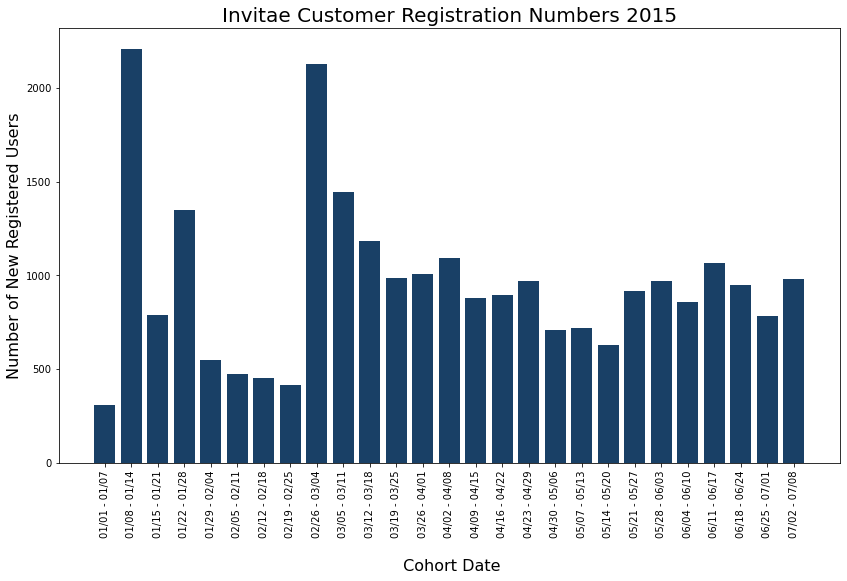

In [116]:
cohort_df.sort_values(by='Cohort', ascending=True, inplace=True)
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(cohort_df['Cohort'], cohort_df['Customers'], color='#194066')
ax.set_title('Invitae Customer Registration Numbers 2015', fontsize=20)
ax.set_xlabel('\n Cohort Date', fontsize=16)
ax.set_ylabel('Number of New Registered Users', fontsize=16)
ax.set_xticklabels(labels=cohort_df['Cohort'], rotation=90, fontsize=10);

In [117]:
plt.savefig('registered_users.svg', transparent=False, bbox_inches='tight', format='svg', dpi=1200)

<Figure size 432x288 with 0 Axes>

In [139]:
df = pd.DataFrame()
first_orders_1, unique_cust_orders_1 = week_range_list_new_total_cust_orders(new_merged_df_2, 'Order_Group_days', 
                                                                      dict_7, 1,'customer_id', 
                                                                         'order_number')
zipped_1 = percent_orderers(new_merged_df_2, 'Order_Group_days', dict_7, 1,'customer_id', 'order_number')
first_lst = []
order_lst = []
first_percent = []
order_percent = []
for num2 in range(0,27):
    first = first_orders_1[num2]
    first_lst.append(first)
    order = unique_cust_orders_1[num2]
    order_lst.append(order)
    first_p = zipped_1[num2][1]
    first_percent.append(first_p)
    order_p = zipped_1[num2][0]
    order_percent.append(order_p) 
df['7-13 days Orders'] = order_lst
df['7-13 days Order %'] = order_percent
df['7-13 days First-Time'] = first_lst
df['7-13 days First-Time%'] = first_percent

In [140]:
df = df.reset_index()


/Users/sambuck92/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


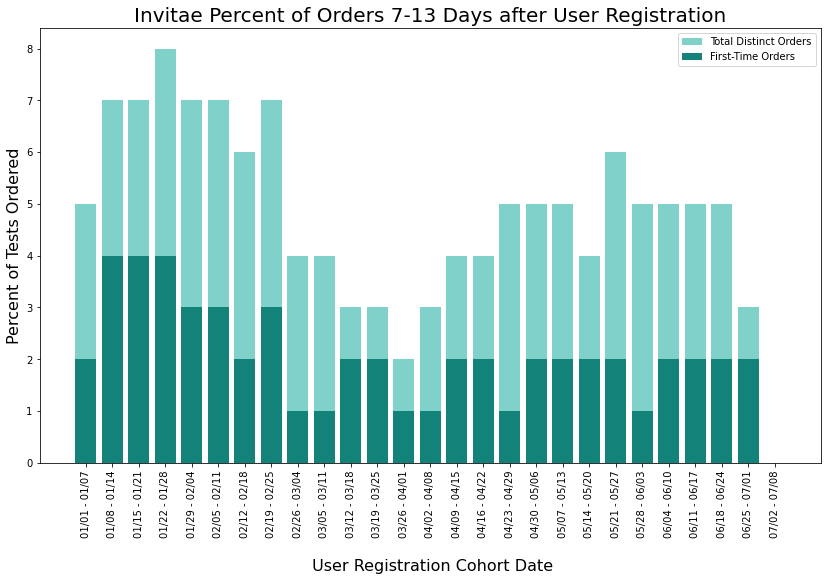

In [141]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(cohort_df['Cohort'], df['7-13 days Order %'], color='#80D1CA', label='Total Distinct Orders')
ax.bar(cohort_df['Cohort'], df['7-13 days First-Time%'],  color='#138279', label='First-Time Orders')
ax.set_title('Invitae Percent of Orders 7-13 Days after User Registration', fontsize=20)
ax.set_xlabel('\n User Registration Cohort Date', fontsize=16)
ax.set_ylabel('Percent of Tests Ordered', fontsize=16)
ax.set_xticklabels(labels=cohort_df['Cohort'], rotation=90, fontsize=10)
ax.legend();


In [142]:
plt.savefig('7-13days_orders.svg', transparent=False, bbox_inches='tight', format='svg', dpi=1200)

<Figure size 432x288 with 0 Axes>

In [143]:
df = pd.DataFrame()
first_orders_1, unique_cust_orders_1 = week_range_list_new_total_cust_orders(new_merged_df_2, 'Order_Group_days', 
                                                                      dict_7, 0,'customer_id', 
                                                                         'order_number')
zipped_1 = percent_orderers(new_merged_df_2, 'Order_Group_days', dict_7, 0,'customer_id', 'order_number')
first_lst = []
order_lst = []
first_percent = []
order_percent = []
for num2 in range(0,27):
    first = first_orders_1[num2]
    first_lst.append(first)
    order = unique_cust_orders_1[num2]
    order_lst.append(order)
    first_p = zipped_1[num2][1]
    first_percent.append(first_p)
    order_p = zipped_1[num2][0]
    order_percent.append(order_p) 
df['0-6 days Orders'] = order_lst
df['0-6 days Order %'] = order_percent
df['0-6 days First-Time'] = first_lst
df['0-6 days First-Time%'] = first_percent

In [144]:
df = df.reset_index()

/Users/sambuck92/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  import sys


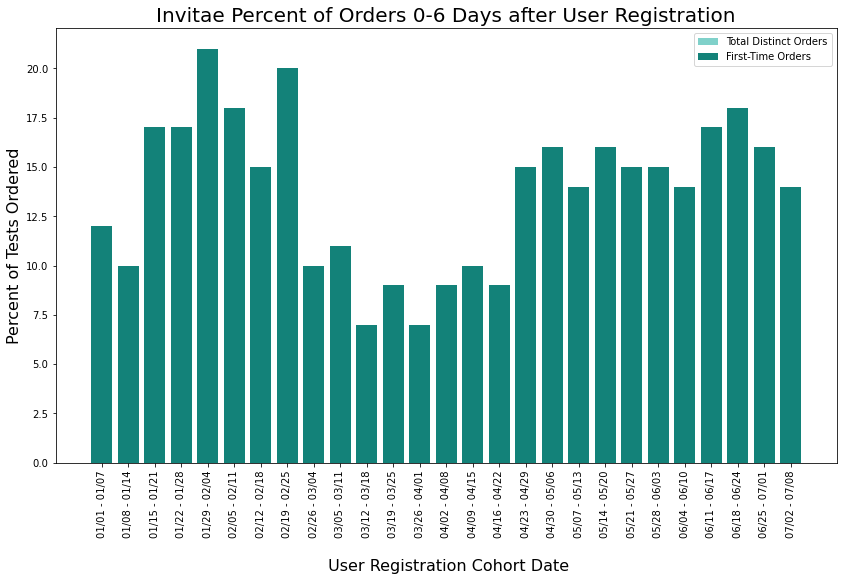

In [145]:
fig, ax = plt.subplots(figsize=(14, 8))
ax.bar(cohort_df['Cohort'], df['0-6 days Order %'], color='#80D1CA', label='Total Distinct Orders')
ax.bar(cohort_df['Cohort'], df['0-6 days First-Time%'],  color='#138279', label='First-Time Orders')
ax.set_title('Invitae Percent of Orders 0-6 Days after User Registration', fontsize=20)
ax.set_xlabel('\n User Registration Cohort Date', fontsize=16)
ax.set_ylabel('Percent of Tests Ordered', fontsize=16)
ax.set_xticklabels(labels=cohort_df['Cohort'], rotation=90, fontsize=10)
ax.legend();


In [146]:
plt.savefig('0-6days_orders.svg', transparent=False, bbox_inches='tight', format='svg', dpi=1200)

<Figure size 432x288 with 0 Axes>